# Time Series Forecasting with Gaussian Processes

Gaussian Processes (GPs) can be applied to a range of time series problems, including forecasting, which is the predicition of future data based on past data. In this notebook we will demonstrate the use of GP regression for forecasting on the Mauna Loa dataset, which consists of carbon dioxide measurements taken from the Mauna Loa volcano in Hawaii over several decades.

We begin by importing the required libraries.

In [2]:
import pandas as pd
import numpy as np
from numpy.linalg import inv, cholesky
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel
from datetime import datetime
from scipy.optimize import minimize
from scipy.linalg import det

Next we fetch the dataset from OpenML via sklearn and put it into a dataframe.

In [3]:
# get the data
co2 = fetch_openml(data_id=41187, as_frame=True)
co2_df = co2.frame
co2_df["Date"] = pd.to_datetime(co2_df[["year", "month", "day"]])
co2_df = co2_df.drop(["year", "month", "day", "weight", "flag", "station"], axis=1).set_index("Date")

Let's visualise the data.

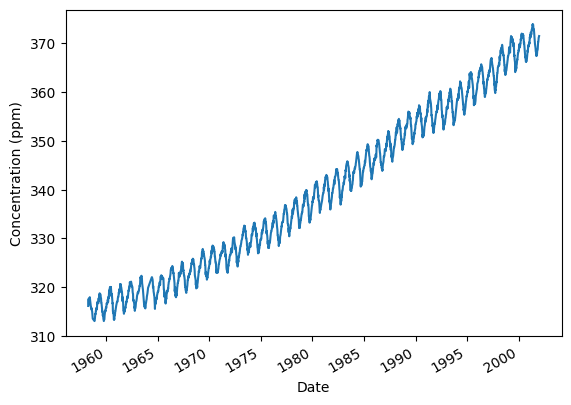

In [4]:
# plot the data
co2_df.plot(ylabel = "Concentration (ppm)", legend=False)
plt.show()

We will check for NaNs and infs, since if these are present we will have to use a strategy to deal with them.

In [5]:
# check for Nans and infs
co2_df.isnull().values.any()

False

Fortunately for us there are no NaNs or infs in the data.

We are going to define a function that converts dates to floats, since to model the data with functions we are going to want to have an input of real numbers, not dates. We cannot use the standard datetime function to convert from dates to floats since it only handles dates after 1970.

Our function will be defined such that dates a year apart will have a difference of one.

In [6]:
def dates_to_floats(dates):
    """Function that converts datetime objects into floats, with 
    zero set to coincide with the date of our first observation."""
    
    reference_time = pd.to_datetime("1958-03-29")
    floats = (dates - reference_time) / pd.Timedelta(365, "D")
    return np.asarray(floats)

# get dates of the observations
dates = co2_df.index
# convert dates to floats
ts = dates_to_floats(dates)
# get observation values
y = co2_df["co2"].values
# find difference between dates a year apart
dates_to_floats(datetime(2000, 1, 1)) - dates_to_floats(datetime(1999, 1, 1))

1.0

Now we will split our data into training and test sets. We will use the training set to fit the GP model and the test set for making and evaluating its predictions. The data from March 1958 up until March 1983 will make up the training set, with the remainder up until the end of 2001 forming the test set.

In [7]:
# separate data into training and test sets
t_train = ts[:1400]
t_test = ts[1400:]
y_train = y[:1400]
y_test = y[1400:]
# centre the observtions on zero, since we will be using a GP prior with zero mean
y_train_mean = np.mean(y_train)
y_train_cen = y_train - y_train_mean

Now we go about choosing a suitable covariance function for the problem. We have already seen the data; let's pretend that we haven't, but that we do have expert knowledge of the problem and have seen similar data taken from many other observatories. We want to form a GP prior capable of generating sample functions that possess the general properties of the unseen data, and to do this we use our expert knowledge to construct an appropriate covariance function.

Employing our expertise, we expect the concentration of carbon dioxide to increase over time in a broadly linear fashion due to human polluting activity. We also expect there to be a seasonal variation which is caused by the absorption of CO<sub>2</sub> by plants in spring and summer and the subsequent release during the decay of autumn and winter (i.e. period of a year).

We are going to utilise the Radial Basis Function (RBF) covariance to model the long-term trend and the periodic covariance to model the seasonal variatons. These are defined as
$$k(\mathbf{x},\mathbf{x}')_{RBF}=\exp\biggl(-\frac{|\mathbf{x}-\mathbf{x}'|^2}{2l^2}\biggr)\tag{1}$$
$$k(\mathbf{x},\mathbf{x}')_{P}=\exp\biggl[-\frac{2}{l^2}\sin^2\biggl(\frac{\pi(\mathbf{x}-\mathbf{x}')}{p}\biggr)\biggr]\tag{2}$$

There are a number of ways we can combine these functions; we are going to simply add them. When computing the Gram matrix $K(X,X)$ where $X$ is the training set of $N$ observations, we wil also add $\sigma_N\mathbf{I}$ to account for noise in the observations.

In [8]:
def noise_kernel(x, noise):
    """Noise to be added to the covariance function when 
    computing between the training data"""
    
    return noise*np.eye(len(x))


def composite_kernel_noise(t_train, a, b, c, d, p, noise=1):
    """ Composite kernel for addition of the RBF and periodic covariance functions
    and noise. For use when computing between the training data only. """
    
    k_rbf = a**2*RBF(length_scale=b)(t_train.reshape(-1,1),t_train.reshape(-1,1))
    k_p = c**2*ExpSineSquared(length_scale=d, periodicity=p)(t_train.reshape(-1,1),t_train.reshape(-1,1))
    k_n = noise_kernel(t_train, noise)
    
    return k_rbf + k_p + k_n


def composite_kernel(x, y, a, b, c, d, p):
    """As above, but for any computations involving the test data."""
    
    k_rbf = a**2*RBF(length_scale=b)(x,y)
    k_p = c**2*ExpSineSquared(length_scale=d, periodicity=p)(x,y)
    
    return k_rbf + k_p

The main drawback of the GP approach is the computational complexity of $\mathcal{O}(N^3)$ for inference and hyperparameter training which is due to the inversion of the matrix $K(X,X)+\sigma_NI$. For very large datasets, GP inference is therefore extremely slow or even infeasible. Several methods have been developed to try to address this issue, with the most popular amongst these being the use of Cholesky decomposition for matrix inversion.

Every symmetric, positive-definite matrix $A$ has a unique Cholesky decomposition
$$A=LL^T$$
where $L$ is a lower triangular matrix with positive diagonal entries.

For noisy observations, the posterior predictive mean obtained from conditioning on a GP prior with zero mean is 
$$\boldsymbol{\mu}_*=K(X_*,X)[K(X,X)+\sigma_N^2I]\:\mathbf{y}\tag{3}$$
We set
$$A=K(X,X)+\sigma_NI$$
$A$ is invertible, so we can write $AA^{-1}=I$. Multiplying from the right by $\mathbf{y}$, we obtain
$$AA^{-1}\mathbf{y}=\mathbf{y}$$
Let the notation $A\:\backslash\:\mathbf{b}$ denote the vector $\mathbf{x}$ that solves $A\mathbf{x}=\mathbf{b}$. We can rewrite the above equation as 
$$LL^TA^{-1}\mathbf{y}=\mathbf{y}$$
$$L^TA^{-1}\mathbf{y}=L\:\backslash\:\mathbf{y}$$
$$A^{-1}\mathbf{y}=L^T\:\backslash\:(L\:\backslash\:\mathbf{y})$$
Therefore, the posterior predictive mean becomes
$$\bar{\mathbf{f}}=K(X_*,X)\:\boldsymbol{\alpha}\tag{4}$$
where $\boldsymbol{\alpha} = L^T\:\backslash\:(L\:\backslash\:\mathbf{y})$.

The posterior covariance is
$$\begin{align}\boldsymbol{\Sigma}_*&=K(X_*,X_*)-K(X_*,X)[K(X_*,X_*)+\sigma_N^2I]^{-1}K(X,X_*)\\\\
&=K(X_*,X_*)-K(X_*,X)A^{-1}K(X,X_*)\end{align}\tag{5}$$

Defining $\mathbf{v}=L\:\backslash \: K(X,X_*)=L^{-1}K(X,X_*)$ we can write
$$\begin{align}\mathbf{v}^T\mathbf{v}&=[L^{-1}K(X,X_*)]^TL^{-1}K(X,X_*)\notag\\\\
&=K(X_*,X)(L^{-1})^TL^{-1}K(X,X_*)\notag\\\\
&=K(X_*,X)(L^{-1})^TL^{-1}K(X,X_*)\notag\\\\
&=K(X_*,X)(L^T)^{-1}L^{-1}K(X,X_*)\notag\\\\
&=K(X_*,X)(LL^T)^{-1}K(X,X_*)\notag\\\\
&=K(X_*,X)A^{-1}K(X,X_*)\notag\end{align}$$

Therefore, we can express the posterior covariance as
$$\boldsymbol{\Sigma}=K(X_*,X_*)-\mathbf{v}^T\mathbf{v}\tag{6}$$

Once again assuming a GP prior with zero mean, the log marginal likelihood is given by
$$\log p(\mathbf{y}|\mathbf{X})=-\frac{1}{2}\mathbf{y}^T[K(X,X)+\sigma_NI]^{-1}\mathbf{y}-\frac{1}{2}\log|K(X,X)+\sigma_NI|-\frac{N}{2}\log(2\pi)\tag{7}$$

We can rewrite $$\begin{align}\log|K(X,X)+\sigma_NI|&=\log|A|\\&=\log|LL^T|\\&=\log(|L||L^T|)\end{align}$$.

If $A$ is a triangular matrix, $|A|=|A^T|=\prod_{i=1}^n A_{ii}$, meaning we can write
$$\begin{align}\log(|L||L^T|)&=\log\biggl[\biggl(\prod_{i=1}^n L_{ii}\biggr)^2\biggr]\\
&=2\sum_{i=1}^n\log(L_{ii})\end{align}$$

Therefore, we can express the log marginal likelihood as
$$\log p(\mathbf{y}|\mathbf{X})=-\frac{1}{2}\mathbf{y}^T\boldsymbol{\alpha}-\sum_{i=1}^n\log(L_{ii})-\frac{N}{2}\log(2\pi)\tag{8}$$

By utilising Cholesky decomposition to reformulate the predictive equations and log marginal likelihood, we have a relatively efficient and numerically stable method to compute GP regression.

In [9]:
def cholesky_f(t_train, params, p):
    """Compute the Cholesky factor."""

    return cholesky(composite_kernel_noise(t_train,params[0],params[1],params[2],params[3], p, params[4]))


def alpha(y_train, L):
    """Compute alpha."""
    
    return np.linalg.solve(L.T, np.linalg.solve(L, y_train))


def log_marginal_likelihood(t_train, y_train, params, p):
    """Compute the log marginal likelihood as defined in equation (8)."""
    
    L = cholesky_f(t_train, params, p)
    lml = -0.5*np.dot(y_train, alpha(y_train, L)) - sum(np.log(np.diag(L))) - len(t_train)*np.log(2*np.pi)/2

    return lml


def posterior_mean(t_train, t_test, y_train, params, p):
    """Compute the posterior mean as defined in equation (4)."""
    
    K_train_test = composite_kernel(t_train.reshape(-1,1), t_test.reshape(-1,1), params[0],params[1],params[2],params[3],p)
    L = cholesky_f(t_train, params, p)
    a = alpha(y_train, L)

    return np.dot(K_train_test.T, a)


def posterior_covariance(t_train, t_test, params, p):
    """Compute the posterior covariance according to equation (6)."""
    
    L = cholesky_f(t_train, params, p)
    K_train_test = composite_kernel(t_train.reshape(-1,1), t_test.reshape(-1,1), params[0],params[1],params[2],params[3],p)
    K_test_test = composite_kernel(t_test.reshape(-1,1), t_test.reshape(-1,1), params[0],params[1],params[2],params[3],p)

    v = np.linalg.solve(L,K_train_test)
    
    return K_test_test - np.dot(v.T, v)


def plot_GP_posterior(mean, cov, t_train, y_train, t_test, y_test):
    """Plots the GP posterior predicitve distribution."""
    
    # get the test point variances
    vars = np.diag(cov).copy()
    # ensure that none of the variances are less than zero (due to float computational errors)
    vars[vars<0]=0
    # get standard deviations from the covariances
    std_devs = np.sqrt(vars)
    # plot the distribution
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(dates[:1400], y_train, label="observations")
    ax.plot(dates[1400:], mean, c='k', label="posterior mean")
    ax.plot(dates[1400:], y_test, c='b', alpha=0.2)
    ax.fill_between(dates[1400:], mean-2*std_devs, mean+2*std_devs, color="r", alpha=0.2, label=r"$\pm$ 2 std. dev.")
    ax.set_ylim(300, 400)
    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel("Concentration (ppm)", fontsize=14)
    ax.set_title("GP posterior")
    plt.legend()
    plt.show()

Instead of maximising the marginal log likelihood we can equivalently minimise its negative. We just have to specify some initial guesses and bounds for the model hyperparameters. Since the log marginal likelihood is not convex, care must be taken with regards to local optima when optimising. Therefore, it is good practice to run the optimisation a number of times with different initial guesses and choose the set that produce the smallest value (since we are minimising) of the log marginal likelihood.

Since the phenomena we are modelling has a period of roughly a year, and we defined the dates_to_floats function so that dates a year apart have a difference of one, we can confidently set the period parameter $p$ in the periodic covariance function, which we are using to model the seasonal variations, as equal to one. We will not train this parameter.

In [10]:
# define the function to minimise, the negative of the log marginal likelihood
f = lambda x: -1*log_marginal_likelihood(t_train, y_train_cen, x, 1)

hyperparams = []
scores = []
# restart the optimisation from randomly initialised values within the specified ranges
# run 5 times and store the hyperparameters and scores
for i in range(5):
    x0 = [np.random.uniform(0,10), np.random.uniform(30,80), np.random.uniform(0,10), np.random.uniform(0,10), np.random.uniform(0,10)]
    res = minimize(f, x0=x0, bounds=[(0.01,10),(30,80),(0.01,10),(0.01,10),(0.01,10)])
    scores.append(res["fun"])
    hyperparams.append(res["x"])
# identify the hyperparameters that produce the lowest score
scores = np.array(scores) 
hyperparams = np.array(hyperparams)
min_idx = np.argmin(scores)
hyperparams_opt = hyperparams[min_idx]

Now we have optimised the model hyperparameters, we can compute the posterior predictive distribution according to equations (4) and (6).

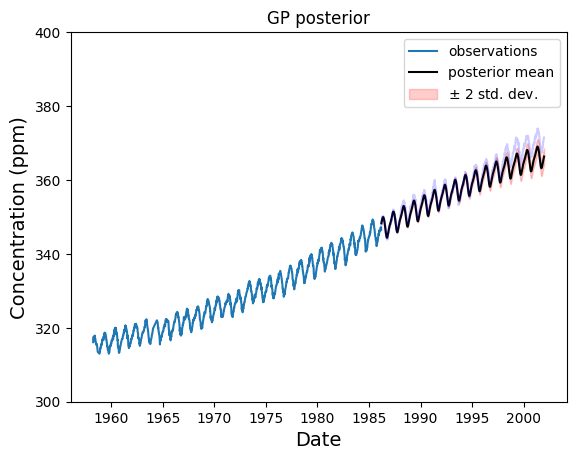

In [11]:
# compute posterior mean
mean = posterior_mean(t_train, t_test, y_train_cen, hyperparams_opt, 1)
# compute posterior covariance
cov = posterior_covariance(t_train, t_test, res['x'], 1)
# plot the posterior distribuion
plot_GP_posterior(mean+y_train_mean, cov, t_train, y_train, t_test, y_test)

By eye the GP looks to provide fairly good predictions for the test data, alhough the predicted values deviate from the true values more noticeably from around 1996 onwards. The uncertainty in the predictions is generally very small, but grows larger the further away the date is from our final training observation in 1986, as is to be expected. To quantify the performance of the GP on the test set and compare between models we could use an evaluation metric such as the root mean square error (RMSE).